In [1]:
import datetime
import numpy as np
import pandas as pd

import aggregator as ag
import monthly_modeler as mm

In [2]:
#data_file_name_review = "distributed_data_collection/databases/review_data_sample.csv"
#data_file_name_book = "distributed_data_collection/databases/book_data_sample.csv"

data_file_name_review = "distributed_data_collection/databases/review_data.csv"
data_file_name_book = "distributed_data_collection/databases/book_data.csv"

start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 11, 29)

book_columns = ["num_reviews", "num_ratings", "avg_rating"]

Theoretically, we could test against multiple grains (ie, day, week, month, quarter). However, I am only working with month. I ruled out the quarterly grain because it wouldn't include enough 2020 time periods to observe a trend in model performance over time. Then because the maximum monthly review counts were in the seventies, I didn't feel I could split those further.

In [3]:
data_aggregator = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns, start_date, end_date, "month")
data = data_aggregator.aggregate("by_book")

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.


I want to drop binary feature columns which have a small number of values. The linear regression regularization will do a rigorous feature selection, so this step is mostly to reduce the amount of data that it has to process.

In [4]:
data = mm.sparsity_filter(data, 2)

Dropped 0/39 columns. 39 columns remaining.


This process will take all the 2018-2019 periods as features and will use those to predict reviews for each 2020 period. Differences in the overall accuracy of each model as well as shifts in the importance of different features to the model may indicate COVID-related change.

In [5]:
time_periods_post = []

for col in data.columns:
    if "review_count" in col:
        if "2020" in col:
            time_periods_post.append(col)

I want to use the same test/train split for every time period, so I need to make the split before selecting which period will be the feature. 

In [6]:
perc_train = 0.75

data = data.iloc[np.random.permutation(data.index)].reset_index(drop=True) #SHUFFLES DATA

num_observations_total = len(data)
num_observations_train = int(num_observations_total* perc_train)
num_observations_test = num_observations_total - num_observations_train

data_train = data.head(num_observations_train).reset_index(drop = True)
data_test = data.tail(num_observations_test).reset_index(drop = True)

We want to iterate through: logorithmic transformation, regularization type, and alpha value. For the moment, I am turning logorithmic transformation off. It's pretty clear that it has no impact, and I don't want to keep running it while I experiment with other aspects of the modeling process.

In [7]:
alpha_list = [1]
regression_types_list = ["linear"]
is_log_options = [False] 

Here goes on modeling! We will select the best model for each time period based on MSE. The performance df captures the overall predictiveness of pre-period data on post-period data. We expect to see declines due to concept drift. Sharp dropoffs in performance might suggest larger changes in reading trends.

In [8]:
regression_processor = mm.Regression_Processor(data_train, data_test, time_periods_post, regression_types_list, is_log_options, alpha_list)
performance_df, model_dict = regression_processor.get_optimal_models()

print(performance_df.round(3))

10/11 models processed
11/11 models processed
   post_period regression_type is_log alpha  mse_test  r2_train  r2_test
0      2020-01          linear  False  None     2.935     0.825    0.756
1      2020-02          linear  False  None     1.870     0.736    0.606
2      2020-03          linear  False  None     2.233     0.706    0.619
3      2020-04          linear  False  None     2.797     0.749    0.698
4      2020-05          linear  False  None     4.450     0.681    0.595
5      2020-06          linear  False  None     5.093     0.577    0.475
6      2020-07          linear  False  None     3.084     0.593    0.548
7      2020-08          linear  False  None     2.078     0.583    0.577
8      2020-09          linear  False  None     2.007     0.552    0.544
9      2020-10          linear  False  None     1.327     0.496    0.406
10     2020-11          linear  False  None     0.021     0.052    0.026


This is where it's really at! Understanding what features are most important to each model can help us understand the drivers of reading in each period.

In [9]:
coefficient_df = regression_processor.get_coefficient_df()
coefficient_df = regression_processor.print_top_coefficients()

                      review_count 2020-01
feature_name                              
review_count 2019-12              0.504065
review_count 2019-11              0.217566
review_count 2019-08              0.172817
review_count 2019-10              0.156594
review_count 2019-07              0.111444
review_count 2018-05              0.100391
review_count 2019-03              0.085956
review_count 2018-11             -0.081760
review_count 2018-04             -0.080670
review_count 2019-09              0.068203
                      review_count 2020-02
feature_name                              
review_count 2019-12              0.262732
review_count 2019-11              0.144524
review_count 2019-10              0.135317
avg_rating                        0.107038
review_count 2019-08              0.098674
review_count 2019-05              0.096569
review_count 2019-07              0.075942
review_count 2019-06              0.051678
review_count 2018-05              0.050669
review_coun

I also want to understand the relative importance of each historical period. Even if it isn't the main driver, it should give some indication of whether trends are changing.

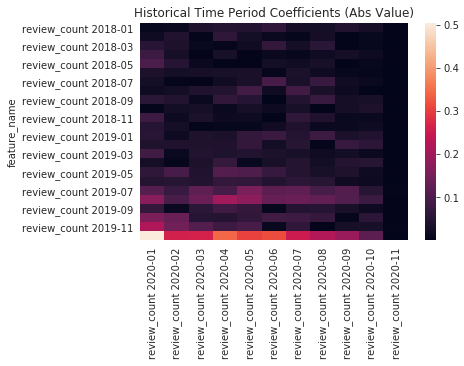

In [10]:
pre_period_importance = regression_processor.get_pre_period_importance()